# 주식 예측에 도전해 보자

## 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/drive/MyDrive/aiffel/Exploration/ex14/data/005930.KS.csv", index_col="Date", parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-03,55600.0,56700.0,55500.0,56400.0,54197.226563,28384920
2020-09-04,55200.0,55800.0,55100.0,55600.0,53428.468750,22139109
2020-09-07,56100.0,57300.0,55800.0,56500.0,54293.320313,18685880
2020-09-08,57400.0,58700.0,57200.0,58700.0,56407.398438,31517520
2020-09-09,58200.0,59300.0,57800.0,58400.0,56119.109375,30597399


In [3]:
ts = df["Close"]
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-09-03    56400.0
2020-09-04    55600.0
2020-09-07    56500.0
2020-09-08    58700.0
2020-09-09    58400.0
Name: Close, dtype: float64

## 데이터전처리

### 결측치 처리

In [4]:
ts=ts.interpolate(method='time')
ts[ts.isna()] 


Series([], Name: Close, dtype: float64)

### 로그변환

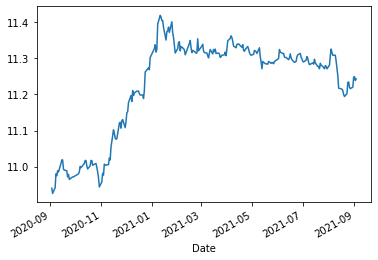

In [5]:
ts_log = np.log(ts)
ts_log.plot()

## 시계열 안정성 분석

### 정성적 그래프 분석

In [6]:
def plot_rolling_statistics(timeseries, window=12):

  rolemean = timeseries.rolling(window=window).mean()
  rolestd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries, color='blue', label="Original")
  mean = plt.plot(rolemean, color='red', label="Rolling Mean")
  std = plt.plot(rolestd, color='black', label="Rolling std")
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag="AIC")

    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


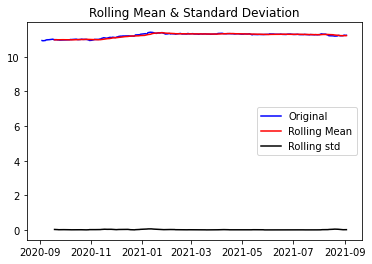

Results of Dickey-Fuller Test:
Test Statistic                  -2.259369
p-value                          0.185407
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


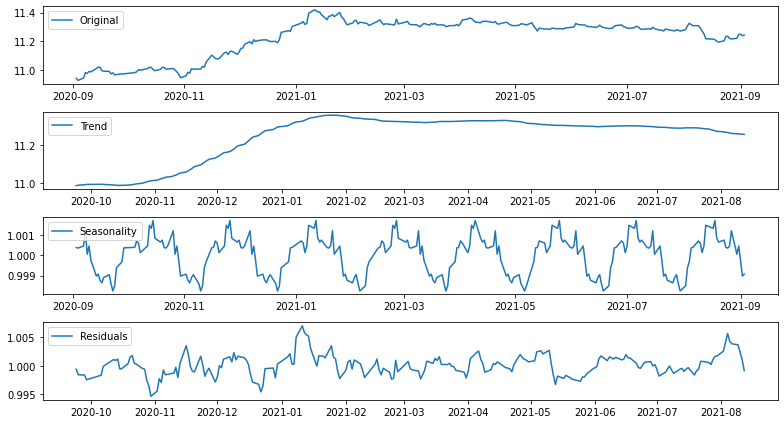

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq=30) 
# [[YOUR CODE]]

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.721727e+00
p-value                        6.916492e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


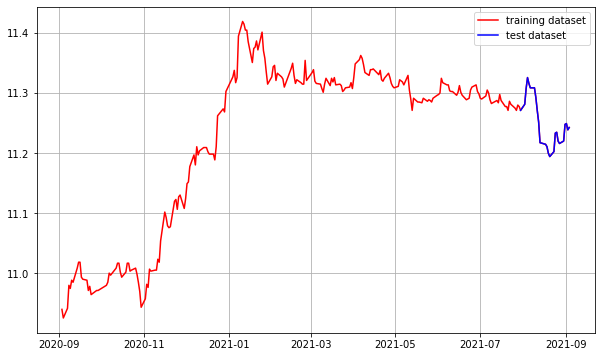

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

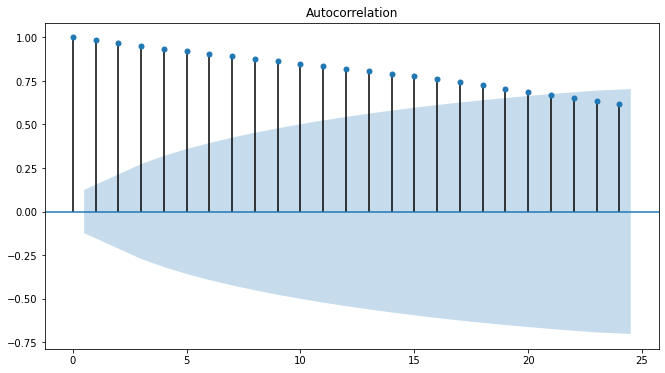

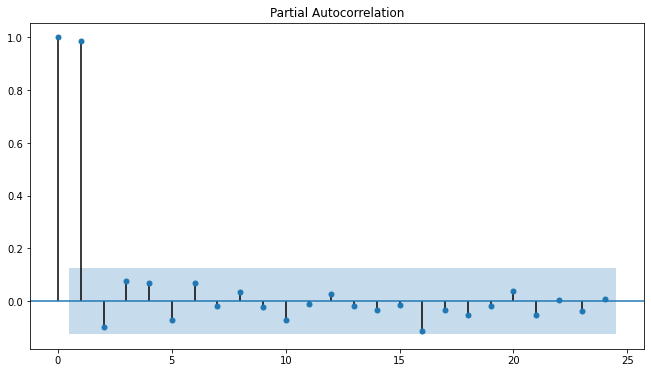

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.149058e+01
p-value                        4.747308e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


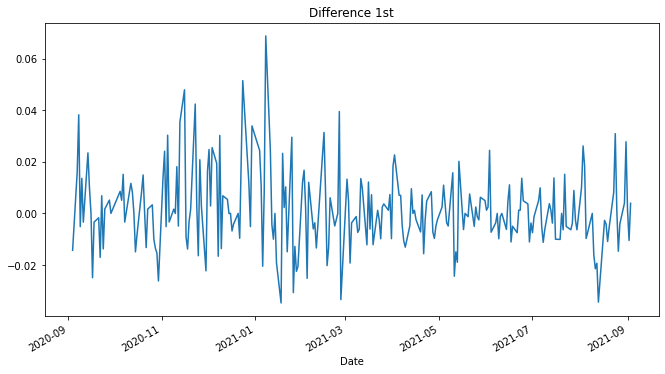

In [12]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  224
Model:                     ARMA(1, 0)   Log Likelihood                 621.367
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 03 Sep 2021   AIC                          -1236.735
Time:                        06:56:26   BIC                          -1226.500
Sample:                             0   HQIC                         -1232.603
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.1456      0.141     78.999      0.000      10.869      11.422
ar.L1.Close     0.9960      0.004    231.575      0.000       0.988       1.004
                                    Roots       

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


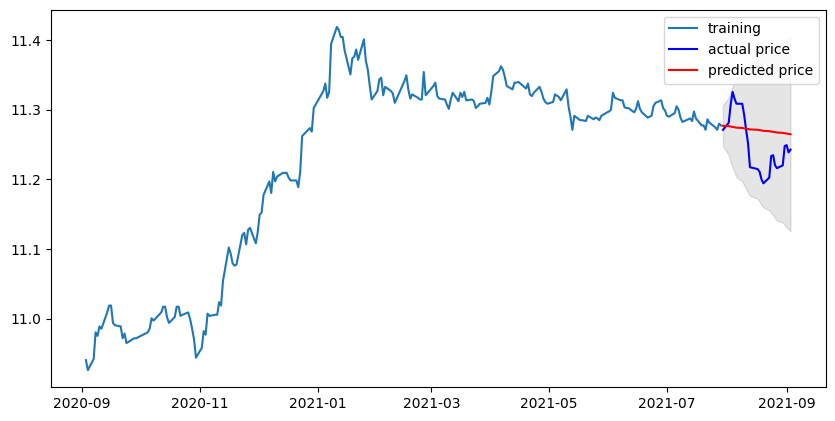

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [15]:


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  10533453.457608888
MAE:  2859.188987322804
RMSE:  3245.528224743838
MAPE: 3.76%


## class 정의

In [16]:
class StockARIMA():

  def __init__(self, stock_file_path):
    self.stock_file_path = stock_file_path
    self.df = pd.read_csv(stock_file_path, index_col="Date", parse_dates=True)
    ts = self.df["Close"]
    self.ts = ts.interpolate(method='time')
    self.ts_log = np.log(ts)
    print("stock_file_path :", stock_file_path)
    print("df :", self.df.head())

  def plot_rolling_statistics(self, timeseries, window=12):

    rolemean = timeseries.rolling(window=window).mean()
    rolestd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue', label="Original")
    mean = plt.plot(rolemean, color='red', label="Rolling Mean")
    std = plt.plot(rolestd, color='black', label="Rolling std")
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

  
  def augmented_dickey_fuller_test(self, timeseries):
    dftest = adfuller(timeseries, autolag="AIC")

    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

  def draw_analyzed_graph(self):
    # 정성적 그래프 분석
    self.plot_rolling_statistics(self.ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    self.augmented_dickey_fuller_test(self.ts_log)

    #시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(self.ts_log, model='multiplicative', freq=30)

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(self.ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    residual.dropna(inplace=True)
    print("===== residual augmented_dickey_fuller_test =====")
    self.augmented_dickey_fuller_test(residual)

  
  def split_train_test_data(self):
    train_data, test_data = self.ts_log[:int(len(self.ts_log)*0.9)], self.ts_log[int(len(self.ts_log)*0.9):]
    self.train_data = train_data
    self.test_data = test_data
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(self.ts_log, c='r', label='training dataset') 
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

  def plot_acf_pacf(self):
    plot_acf(self.ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(self.ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

  def diff(self, time_series):
    return time_series.diff(periods=1).iloc[1:]

  def fit(self, p, d, q):
    # Build Model
    model = ARIMA(self.train_data, order=(p, d, q))  
    self.fitted_m = model.fit(disp=-1)  
    print(self.fitted_m.summary())

  def forecast(self):
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = self.fitted_m.forecast(len(self.test_data), alpha=0.05)  # 95% conf
    self.fc, self.se, self.conf = fc, se, conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=self.test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=self.test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=self.test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(self.train_data, label='training')
    plt.plot(self.test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()


  def evaluate(self):
    mse = mean_squared_error(np.exp(self.test_data), np.exp(self.fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(self.test_data), np.exp(self.fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(self.test_data), np.exp(self.fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(self.fc) - np.exp(self.test_data))/np.abs(np.exp(self.test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

## 삼성전자

In [17]:
samsung = StockARIMA("/content/drive/MyDrive/aiffel/Exploration/ex14/data/005930.KS.csv")

stock_file_path : /content/drive/MyDrive/aiffel/Exploration/ex14/data/005930.KS.csv
df :                Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2020-09-03  55600.0  56700.0  55500.0  56400.0  54197.226563  28384920
2020-09-04  55200.0  55800.0  55100.0  55600.0  53428.468750  22139109
2020-09-07  56100.0  57300.0  55800.0  56500.0  54293.320313  18685880
2020-09-08  57400.0  58700.0  57200.0  58700.0  56407.398438  31517520
2020-09-09  58200.0  59300.0  57800.0  58400.0  56119.109375  30597399


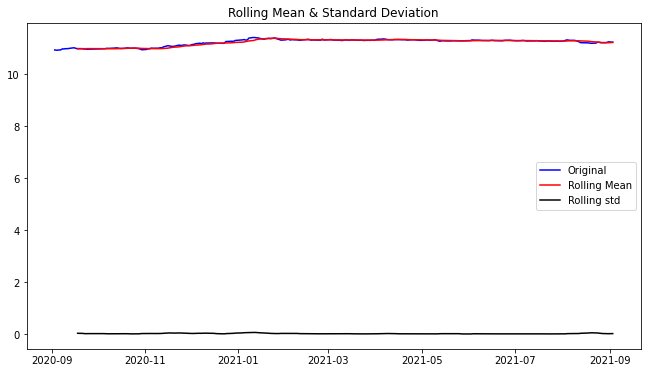

Results of Dickey-Fuller Test:
Test Statistic                  -2.259369
p-value                          0.185407
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
===== residual augmented_dickey_fuller_test =====
Results of Dickey-Fuller Test:
Test Statistic                -5.721727e+00
p-value                        6.916492e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


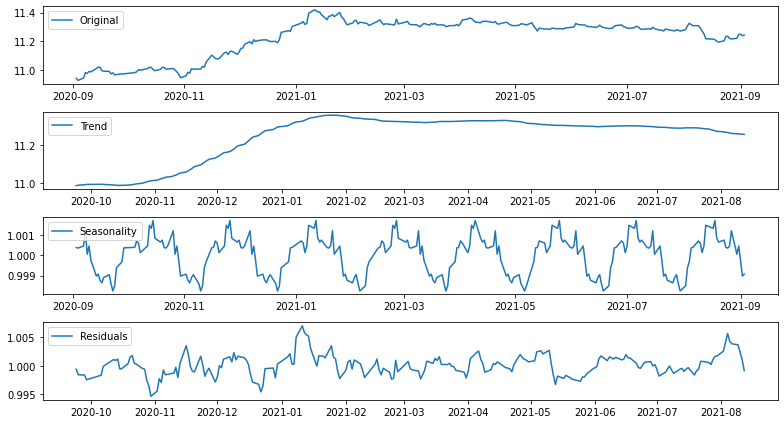

In [18]:
samsung.draw_analyzed_graph()

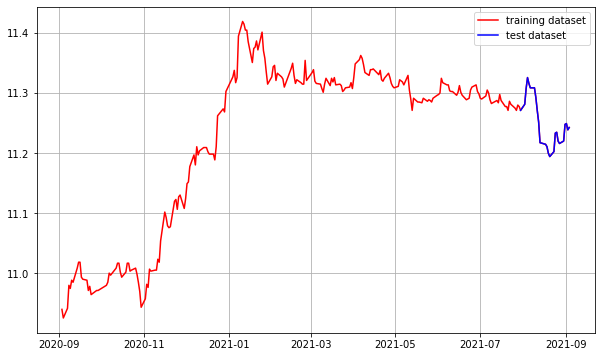

In [19]:
samsung.split_train_test_data()

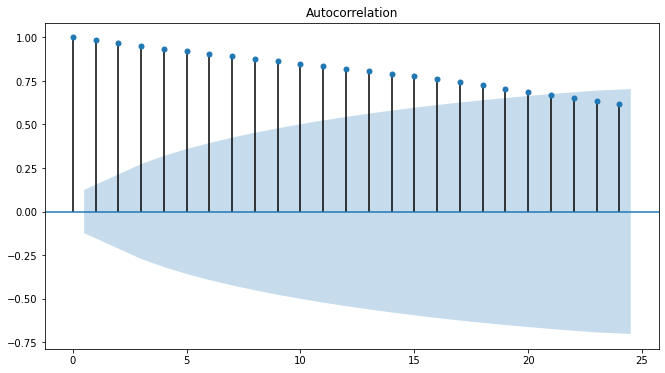

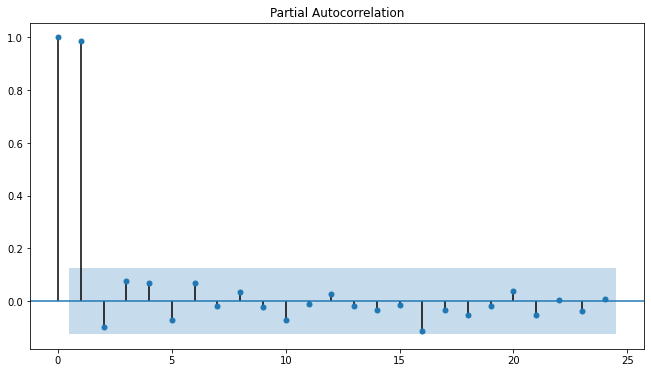

In [20]:
samsung.plot_acf_pacf()

Results of Dickey-Fuller Test:
Test Statistic                -1.149058e+01
p-value                        4.747308e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


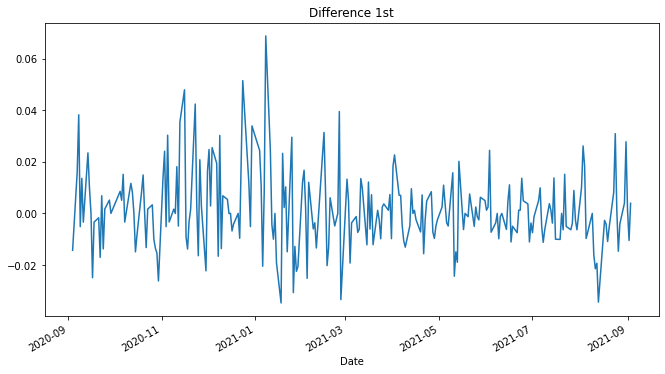

In [21]:
diff_1 = samsung.diff(samsung.ts_log)
diff_1.plot(title='Difference 1st')
samsung.augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.990052e+00
p-value                        7.786918e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


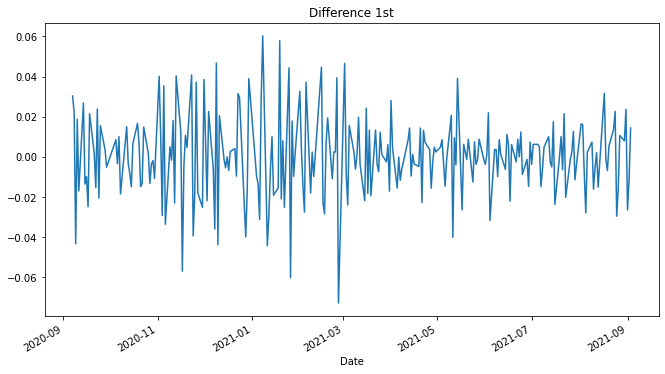

In [22]:
diff_2 = samsung.diff(diff_1)
diff_2.plot(title='Difference 1st')
samsung.augmented_dickey_fuller_test(diff_2)

In [23]:
samsung.fit(1,1,0)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 622.071
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 03 Sep 2021   AIC                          -1238.141
Time:                        06:56:30   BIC                          -1227.920
Sample:                             1   HQIC                         -1234.015
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      1.461      0.145      -0.001       0.004
ar.L1.D.Close     0.0353      0.067      0.527      0.599      -0.096       0.166
                                    Root

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


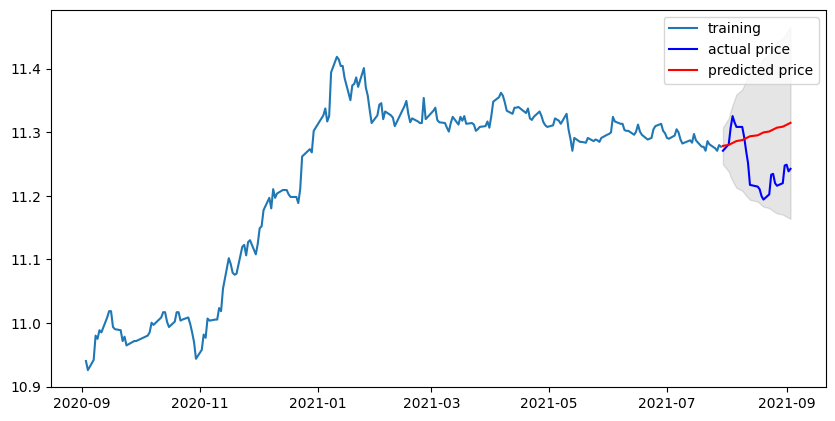

In [24]:
samsung.forecast()

In [25]:
samsung.evaluate()

MSE:  26390488.77359178
MAE:  4496.317204878725
RMSE:  5137.167388122736
MAPE: 5.96%


## LG 생활건강

In [26]:
lg_helthcare = StockARIMA("/content/drive/MyDrive/aiffel/Exploration/ex14/data/051900.KS.csv")

stock_file_path : /content/drive/MyDrive/aiffel/Exploration/ex14/data/051900.KS.csv
df :                  Open       High        Low      Close    Adj Close  Volume
Date                                                                       
2020-09-03  1485000.0  1506000.0  1483000.0  1483000.0  1473040.875   20737
2020-09-04  1482000.0  1483000.0  1445000.0  1453000.0  1443242.375   32181
2020-09-07  1436000.0  1476000.0  1436000.0  1475000.0  1465094.625   22370
2020-09-08  1478000.0  1493000.0  1465000.0  1493000.0  1482973.750   22557
2020-09-09  1510000.0  1513000.0  1480000.0  1510000.0  1499859.500   36196


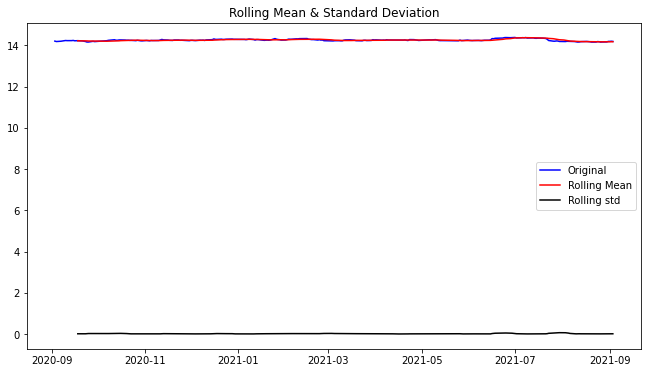

Results of Dickey-Fuller Test:
Test Statistic                  -2.475270
p-value                          0.121608
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
===== residual augmented_dickey_fuller_test =====
Results of Dickey-Fuller Test:
Test Statistic                  -4.937807
p-value                          0.000029
#Lags Used                       0.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


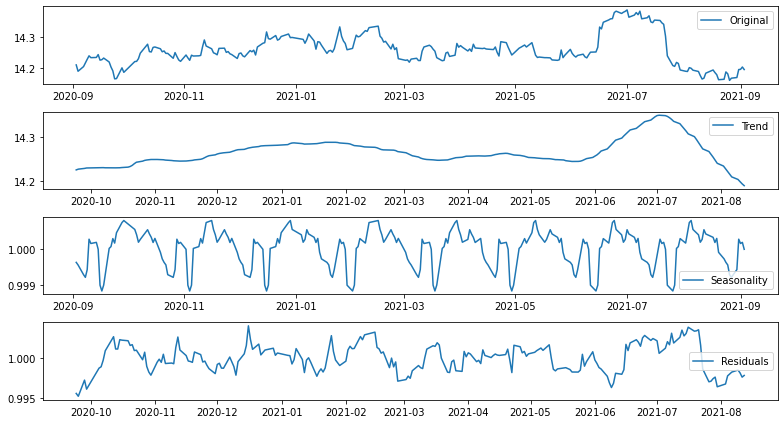

In [27]:
lg_helthcare.draw_analyzed_graph()

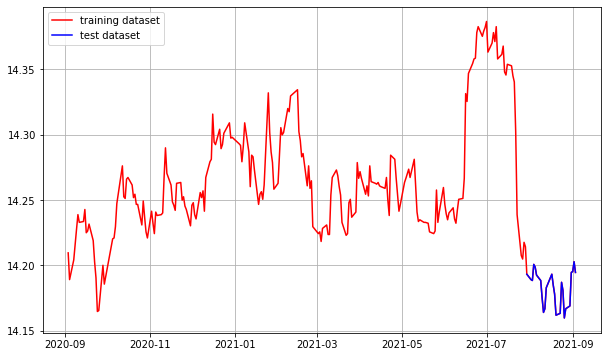

In [28]:
lg_helthcare.split_train_test_data()

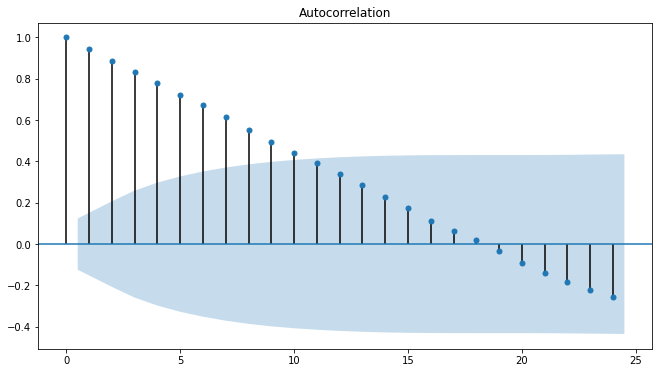

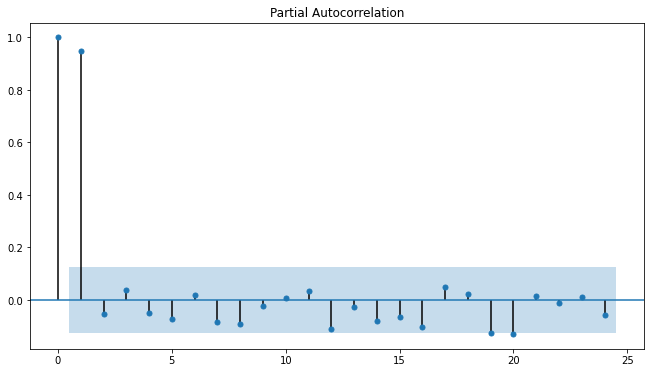

In [29]:
lg_helthcare.plot_acf_pacf()

Results of Dickey-Fuller Test:
Test Statistic                -1.549745e+01
p-value                        2.440110e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


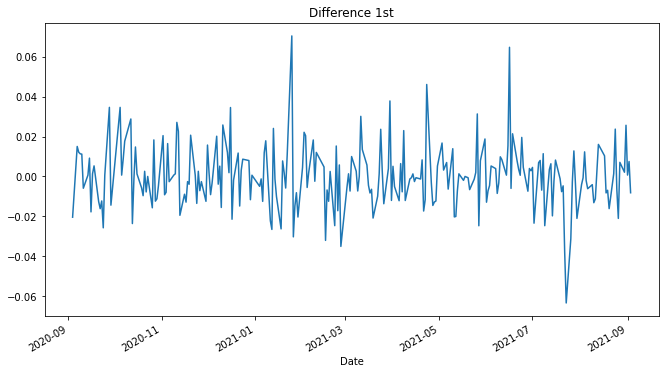

In [30]:
diff_1 = lg_helthcare.diff(lg_helthcare.ts_log)
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.284952e+00
p-value                        4.416302e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


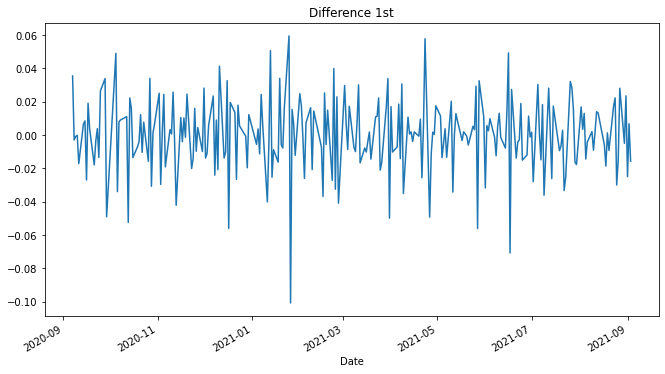

In [31]:
diff_2 = lg_helthcare.diff(diff_1)
diff_2.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_2)

In [32]:
lg_helthcare.fit(0,1,1)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 603.911
Method:                       css-mle   S.D. of innovations              0.016
Date:                Fri, 03 Sep 2021   AIC                          -1201.823
Time:                        06:56:33   BIC                          -1191.601
Sample:                             1   HQIC                         -1197.696
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.053e-05      0.001      0.019      0.985      -0.002       0.002
ma.L1.D.Close     0.0054      0.071      0.077      0.939      -0.133       0.144
                                    Root

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


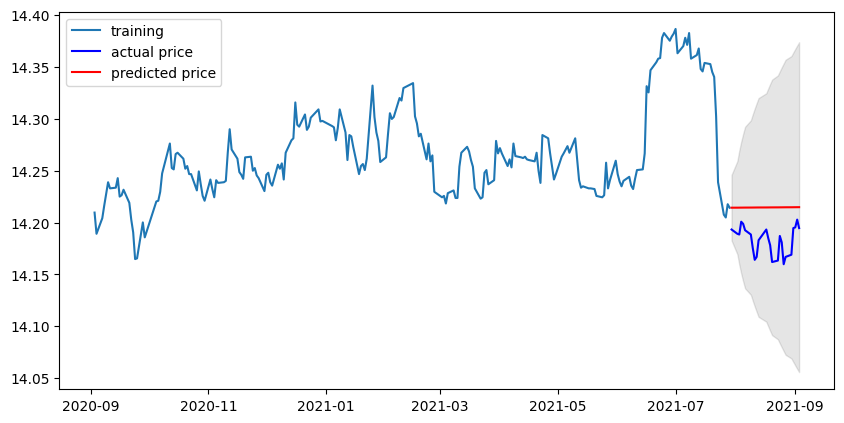

In [33]:
lg_helthcare.forecast()

In [34]:
lg_helthcare.evaluate()

MSE:  2499813860.0709276
MAE:  46249.85636987837
RMSE:  49998.13856605991
MAPE: 3.22%


## 코카콜라

In [35]:
coke_cola = StockARIMA("/content/drive/MyDrive/aiffel/Exploration/ex14/data/KO.csv")

stock_file_path : /content/drive/MyDrive/aiffel/Exploration/ex14/data/KO.csv
df :                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-09-03  51.400002  52.139999  50.099998  50.480000  48.906433  22289400
2020-09-04  50.939999  51.470001  50.279999  51.040001  49.448982  21019500
2020-09-08  50.930000  51.040001  49.360001  49.810001  48.257320  17776700
2020-09-09  49.599998  50.759998  49.549999  50.189999  48.625477  15252300
2020-09-10  50.349998  50.680000  49.950001  50.000000  48.441399  15439500


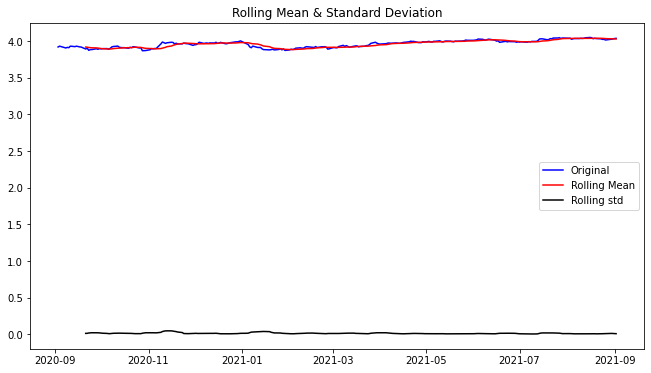

Results of Dickey-Fuller Test:
Test Statistic                  -1.523210
p-value                          0.522000
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
===== residual augmented_dickey_fuller_test =====
Results of Dickey-Fuller Test:
Test Statistic                -5.889675e+00
p-value                        2.944619e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


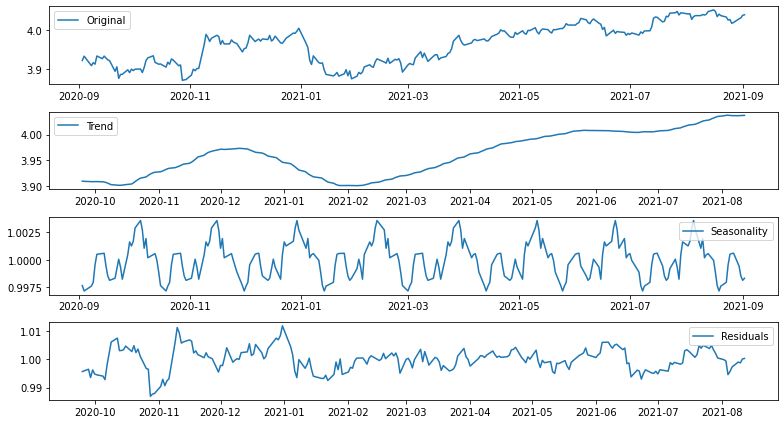

In [36]:
coke_cola.draw_analyzed_graph()

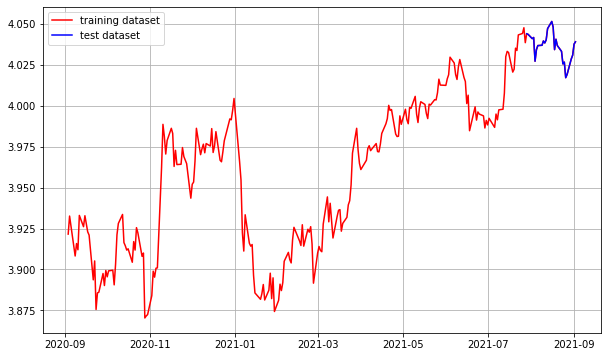

In [37]:
coke_cola.split_train_test_data()

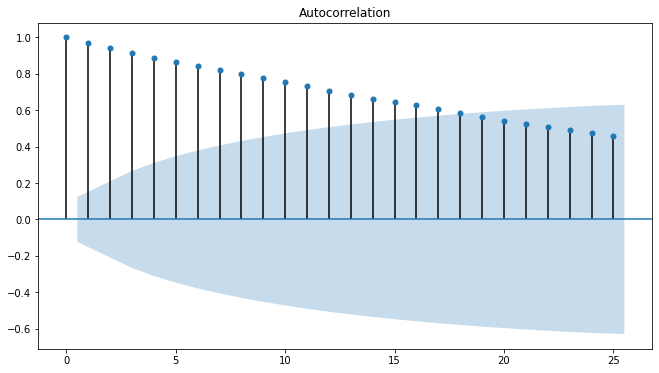

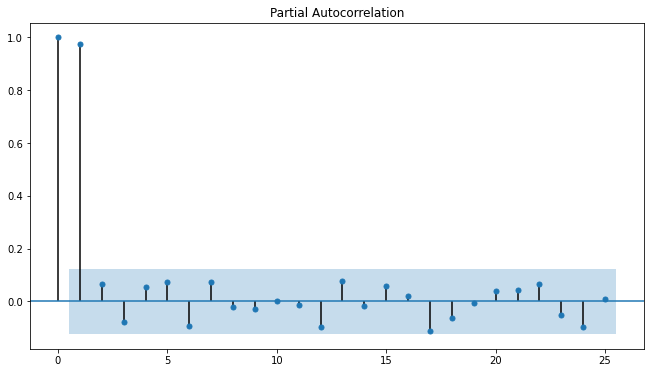

In [38]:
coke_cola.plot_acf_pacf()

Results of Dickey-Fuller Test:
Test Statistic                -6.981475e+00
p-value                        8.171000e-10
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


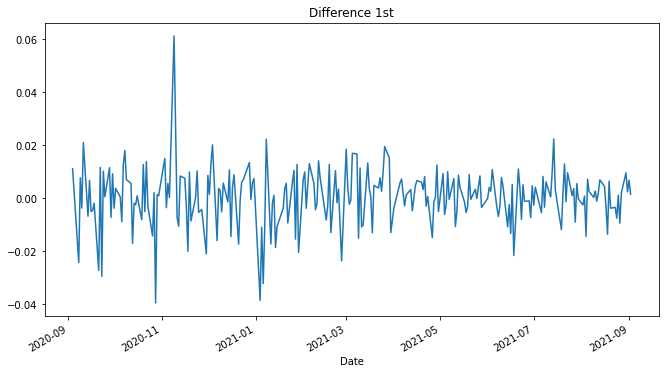

In [39]:
diff_1 = coke_cola.diff(coke_cola.ts_log)
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.273977e+00
p-value                        1.561816e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


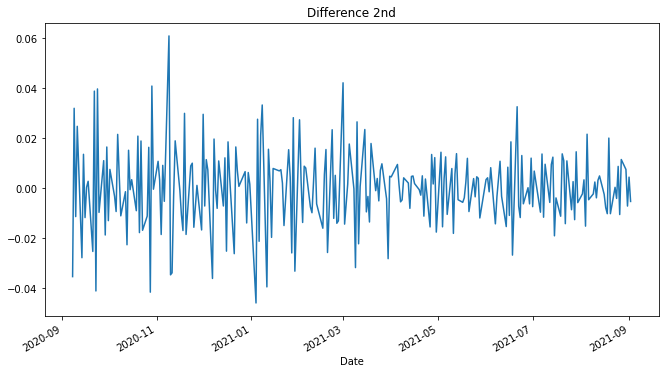

In [40]:
diff_2 = coke_cola.diff(diff_1)
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [41]:
coke_cola.fit(0,1,0)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 687.818
Method:                           css   S.D. of innovations              0.011
Date:                Fri, 03 Sep 2021   AIC                          -1371.636
Time:                        06:56:36   BIC                          -1364.804
Sample:                             1   HQIC                         -1368.879
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.685      0.494      -0.001       0.002


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


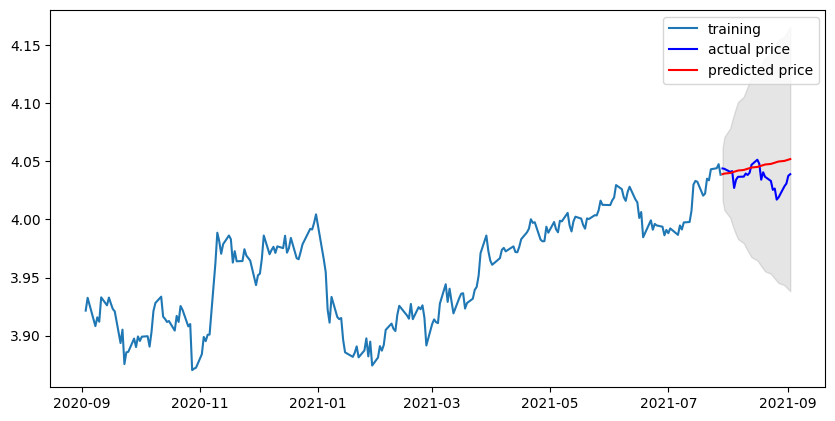

In [42]:
coke_cola.forecast()

In [43]:
coke_cola.evaluate()

MSE:  0.6453189303464697
MAE:  0.6279953708135861
RMSE:  0.8033174530324046
MAPE: 1.12%
